In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize

import re
import cv2
from PIL import Image

In [2]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

[0, 1, 2, 3, 4]

## Load and Split dataset

In [4]:
# specify image folder
image_folder = 'train_images'
extension = '.png'

In [5]:
# check for dublicates
df.duplicated().sum()

0

In [6]:
# get label df columns
df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [7]:
# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

In [8]:
X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

In [10]:
X_train.shape,X_test.shape, X_val.shape

((2343, 299, 299, 3), (733, 299, 299, 3), (586, 299, 299, 3))

In [11]:
y_train.shape,y_test.shape, y_val.shape

((2343,), (733,), (586,))

In [12]:
# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

In [13]:
# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

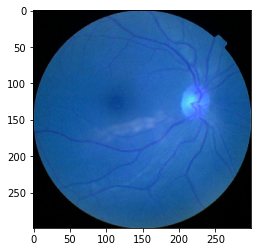

In [14]:
plt.imshow(X_val[76])

## Evaluation functions

In [15]:
# Accuracy and Loss curves
def plot_acc_loss(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

In [16]:
# display confusion matrix heatmap
def confusion_heatmap(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.set(title='Confusion Matrix for the InceptionV3 model')
    disp.plot(ax = ax)
    plt.show()

In [17]:
# calculate weighted_average specificity
def weighted_average_specificity(cm):
    num_classes = 5
    class_counts = []

    for class_label in range(num_classes):
        # Create  binary classification for the current class
        binary_test = [1 if label == class_label else 0 for label in y_test]
         # Count the number of samples for the current class
        class_counts.append(sum(binary_test))
    print(class_counts)   

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity = np.average(specificity, weights = class_counts)
    return specificity

In [18]:
# calculate macro_average specificity
def macro_average_specificity(cm):

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity =np.mean(specificity)
    return specificity

In [19]:
# Calculate the micro-average AUC
def micro_average_auc(y_pred):
    
    micro_avg_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    return micro_avg_auc



In [20]:
# roc curve
def roc_plot(y_pred):

# Binarize actual test labels 
    y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute the ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
   
    # Plot the micro-average ROC curve
    plt.figure(figsize=(6, 4))
    
    plt.plot(fpr, tpr, color='deeppink', linestyle='-', lw=1)         

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
    plt.show()


## Model Development and Training

In [21]:
# function to build model
def build_model(pre_trained_network, lr, dropout):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation = 'softmax'))
    print(model.summary())
    
    #compile model
    #specify optimizer, loss and earlytopping
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)
    
    return model

In [22]:
colour_channel =3
epochs = 50
METRICS=['accuracy']
patience = 10
num_classes = 5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Build and train model 1 - Inception V3 (hp_tuned)

In [25]:
Inception_batch_size = 32
inception_lr = 0.0001
inception_dropout = 0.5
new_epoch =60

In [27]:
InceptionV3_model = build_model(InceptionV3, inception_lr, inception_dropout)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [29]:
InceptionV3_model_history = InceptionV3_model.fit(X_train, y_train, batch_size = Inception_batch_size, epochs = new_epoch, validation_data =(X_val, y_val), shuffle =True, callbacks = [callback])
                                            

Epoch 1/60
74/74 [==============================] - 85s 1s/step - loss: 1.3730 - accuracy: 0.4678 - val_loss: 1.2031 - val_accuracy: 0.5102
Epoch 2/60
74/74 [==============================] - 78s 1s/step - loss: 1.2430 - accuracy: 0.5587 - val_loss: 1.0979 - val_accuracy: 0.5870
Epoch 3/60
74/74 [==============================] - 78s 1s/step - loss: 1.1528 - accuracy: 0.6005 - val_loss: 1.0212 - val_accuracy: 0.6485
Epoch 4/60
74/74 [==============================] - 83s 1s/step - loss: 1.0778 - accuracy: 0.6342 - val_loss: 0.9728 - val_accuracy: 0.6672
Epoch 5/60
74/74 [==============================] - 85s 1s/step - loss: 1.0432 - accuracy: 0.6364 - val_loss: 0.9278 - val_accuracy: 0.6877
Epoch 6/60
74/74 [==============================] - 89s 1s/step - loss: 1.0044 - accuracy: 0.6530 - val_loss: 0.8922 - val_accuracy: 0.6945
Epoch 7/60
74/74 [==============================] - 87s 1s/step - loss: 0.9634 - accuracy: 0.6782 - val_loss: 0.8683 - val_accuracy: 0.6962
Epoch 8/60
74/74 [==

74/74 [==============================] - 81s 1s/step - loss: 0.6108 - accuracy: 0.7751 - val_loss: 0.5990 - val_accuracy: 0.7867
Epoch 60/60
74/74 [==============================] - 81s 1s/step - loss: 0.5953 - accuracy: 0.7742 - val_loss: 0.6023 - val_accuracy: 0.7799


In [30]:
# save model
InceptionV3_model.save('hp2/unprocessed_InceptionV3_model1.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


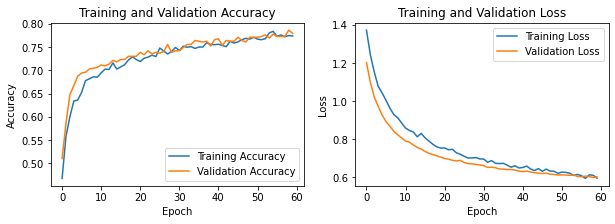

In [31]:
plot_acc_loss(InceptionV3_model_history)

### Evaluate Inception model 

In [32]:
# Predict on test set
inceptionv3_y_pred = InceptionV3_model.predict(X_test)

23/23 [==============================] - 19s 807ms/step


In [33]:
# Classification report
inceptionv3_y_pred_labels = np.argmax(inceptionv3_y_pred, axis=1)
print(classification_report(y_test, inceptionv3_y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       351
           1       0.62      0.31      0.41        68
           2       0.61      0.87      0.72       213
           3       0.67      0.11      0.19        36
           4       0.46      0.09      0.15        65

    accuracy                           0.76       733
   macro avg       0.65      0.47      0.48       733
weighted avg       0.74      0.76      0.72       733



In [32]:
# Confusion matrix
inceptionv3_conf_matrix = confusion_matrix(y_test, inceptionv3_y_pred_labels)

print(inceptionv3_conf_matrix)

[[341   5   5   0   0]
 [ 15  12  40   0   1]
 [ 17   2 194   0   0]
 [  0   0  33   3   0]
 [  5   0  55   1   4]]


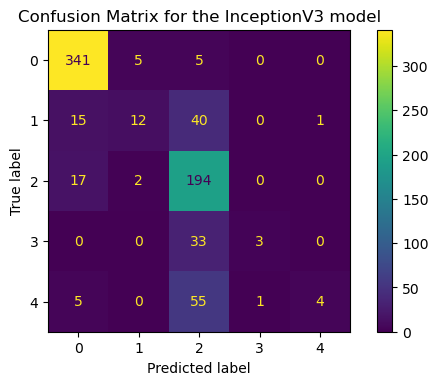

In [33]:
# confusion matrix
confusion_heatmap(inceptionv3_conf_matrix)

In [34]:
# weighted average specificity
inception_wa_specificity = weighted_average_specificity(inceptionv3_conf_matrix)
print(inception_wa_specificity)

[351, 68, 213, 36, 65]
0.8781159984393332


In [35]:
inception_ma_specificity = macro_average_specificity(inceptionv3_conf_matrix)
print(inception_ma_specificity)

0.9267828176960521


In [36]:
micro_avg_auc = micro_average_auc(inceptionv3_y_pred)
print("Micro-Average AUC:", micro_avg_auc)


Micro-Average AUC: 0.8896564519847295


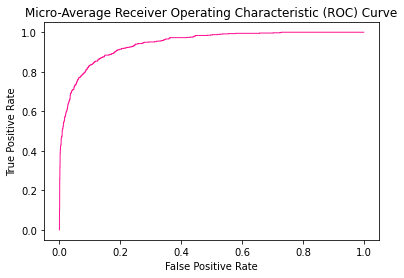

In [37]:
roc_plot(inceptionv3_y_pred)

## Build and train model 2 - ResNet152

In [57]:
resnet_lr = 0.0001
resnet_dropout = 0.4
resnet_batch = 16

In [58]:
# build and compile model
resnet152_model = build_model(ResNet152, resnet_lr, resnet_dropout )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 10, 10, 2048)      58370944  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58381189 (222.71 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
None


In [61]:
# fit resnet model
resnet152_model_history = resnet152_model.fit(X_train, y_train, batch_size = resnet_batch, epochs = new_epoch, validation_data =(X_val, y_val), shuffle = True, callbacks = [callback])


Epoch 1/60
147/147 [==============================] - 522s 4s/step - loss: 1.6659 - accuracy: 0.3807 - val_loss: 1.3018 - val_accuracy: 0.4693
Epoch 2/60
147/147 [==============================] - 488s 3s/step - loss: 1.5081 - accuracy: 0.4409 - val_loss: 1.2886 - val_accuracy: 0.4693
Epoch 3/60
147/147 [==============================] - 484s 3s/step - loss: 1.4894 - accuracy: 0.4324 - val_loss: 1.2863 - val_accuracy: 0.4693
Epoch 4/60
147/147 [==============================] - 479s 3s/step - loss: 1.4585 - accuracy: 0.4486 - val_loss: 1.2580 - val_accuracy: 0.4676
Epoch 5/60
147/147 [==============================] - 473s 3s/step - loss: 1.4493 - accuracy: 0.4481 - val_loss: 1.2531 - val_accuracy: 0.4693
Epoch 6/60
147/147 [==============================] - 463s 3s/step - loss: 1.4136 - accuracy: 0.4588 - val_loss: 1.2935 - val_accuracy: 0.4693
Epoch 7/60
147/147 [==============================] - 455s 3s/step - loss: 1.4107 - accuracy: 0.4622 - val_loss: 1.2391 - val_accuracy: 0.4710

Epoch 58/60
147/147 [==============================] - 466s 3s/step - loss: 1.0558 - accuracy: 0.6231 - val_loss: 1.0082 - val_accuracy: 0.6229
Epoch 59/60
147/147 [==============================] - 473s 3s/step - loss: 1.0594 - accuracy: 0.6159 - val_loss: 0.9964 - val_accuracy: 0.6297
Epoch 60/60
147/147 [==============================] - 466s 3s/step - loss: 1.0563 - accuracy: 0.6244 - val_loss: 1.0151 - val_accuracy: 0.5939


In [62]:
# save model
resnet152_model.save('hp/unprocessed_ResNet152_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


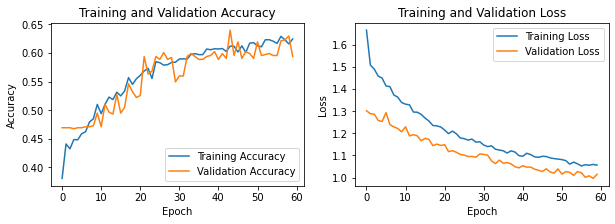

In [63]:
plot_acc_loss(resnet152_model_history)

### Evaluate ResNet152 model

In [64]:
# Predict on test set
resnet152_y_pred = resnet152_model.predict(X_test)

23/23 [==============================] - 86s 4s/step


In [65]:
# Classification report
resnet152_y_pred_labels = np.argmax(resnet152_y_pred, axis=1)
print(classification_report(y_test, resnet152_y_pred_labels))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       351
           1       0.00      0.00      0.00        68
           2       0.64      0.49      0.56       213
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        65

    accuracy                           0.62       733
   macro avg       0.25      0.30      0.26       733
weighted avg       0.48      0.62      0.53       733



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Confusion matrix
resnet152_conf_matrix = confusion_matrix(y_test, resnet152_y_pred_labels)

print(resnet152_conf_matrix)

[[350   0   1   0   0]
 [ 40   0  28   0   0]
 [108   0 105   0   0]
 [ 26   0  10   0   0]
 [ 44   0  21   0   0]]


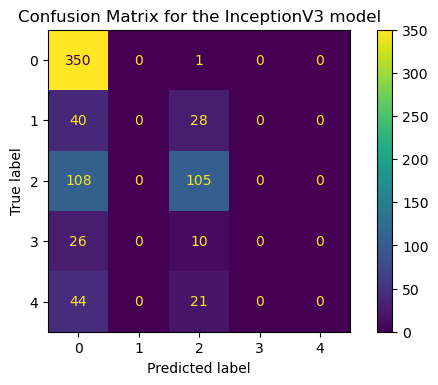

In [67]:
# confusion matrix heatmap
confusion_heatmap(resnet152_conf_matrix)

In [68]:
# weighted average specificity
resnet152_wa_specificity = weighted_average_specificity(resnet152_conf_matrix)
print(resnet152_wa_specificity)

[351, 68, 213, 36, 65]
0.6931980578438155


In [69]:
# macro avg specificity
resnet152_ma_specificity = macro_average_specificity(resnet152_conf_matrix)
print(resnet152_ma_specificity)

0.8627869512686267


In [70]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(resnet152_y_pred)
print("ResNet152 Micro-Average AUC:", micro_avg_auc)


ResNet152 Micro-Average AUC: 0.7951683421434856


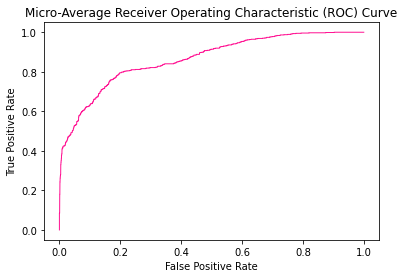

In [71]:
roc_plot(resnet152_y_pred)

## Build and train model 3 - InceptionResNetV2

In [43]:
InceptionResnet_lr = 0.0001
InceptionResnet_dropout = 0.4
InceptionResnet_batch = 32

In [44]:
# build anad compile model
inceptionResnet_model = build_model(InceptionResNetV2, InceptionResnet_lr,InceptionResnet_dropout )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________
None


In [45]:
# fit resnet model
inceptionResnet_model_history = inceptionResnet_model.fit(X_train, y_train, batch_size = InceptionResnet_batch, epochs = new_epoch, validation_data =(X_val, y_val),shuffle = True, callbacks = [callback])


Epoch 1/60
74/74 [==============================] - 216s 3s/step - loss: 1.4082 - accuracy: 0.4528 - val_loss: 1.2012 - val_accuracy: 0.5273
Epoch 2/60
74/74 [==============================] - 210s 3s/step - loss: 1.2642 - accuracy: 0.5480 - val_loss: 1.1137 - val_accuracy: 0.5700
Epoch 3/60
74/74 [==============================] - 216s 3s/step - loss: 1.1675 - accuracy: 0.5945 - val_loss: 1.0485 - val_accuracy: 0.6160
Epoch 4/60
74/74 [==============================] - 216s 3s/step - loss: 1.1058 - accuracy: 0.6219 - val_loss: 0.9970 - val_accuracy: 0.6468
Epoch 5/60
74/74 [==============================] - 218s 3s/step - loss: 1.0598 - accuracy: 0.6381 - val_loss: 0.9504 - val_accuracy: 0.6724
Epoch 6/60
74/74 [==============================] - 214s 3s/step - loss: 1.0408 - accuracy: 0.6475 - val_loss: 0.9217 - val_accuracy: 0.6758
Epoch 7/60
74/74 [==============================] - 214s 3s/step - loss: 0.9893 - accuracy: 0.6628 - val_loss: 0.9025 - val_accuracy: 0.6843
Epoch 8/60
74

Epoch 59/60
74/74 [==============================] - 208s 3s/step - loss: 0.6540 - accuracy: 0.7563 - val_loss: 0.6382 - val_accuracy: 0.7628
Epoch 60/60
74/74 [==============================] - 212s 3s/step - loss: 0.6503 - accuracy: 0.7495 - val_loss: 0.6359 - val_accuracy: 0.7662


In [46]:
# save model
inceptionResnet_model.save('hp/unprocessed_inceptionResnet_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


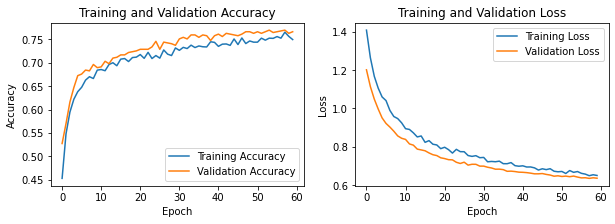

In [47]:
# plot loss and accuracy
plot_acc_loss(inceptionResnet_model_history)

### Evaluate InceptionResNetV2 model

In [48]:
# Predict on test set
inceptionResnet_y_pred = inceptionResnet_model.predict(X_test)

23/23 [==============================] - 55s 2s/step


In [49]:
# Classification report
inceptionResnet_y_pred_labels = np.argmax(inceptionResnet_y_pred, axis=1)
print(classification_report(y_test, inceptionResnet_y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       351
           1       0.54      0.19      0.28        68
           2       0.58      0.88      0.70       213
           3       1.00      0.03      0.05        36
           4       0.40      0.03      0.06        65

    accuracy                           0.74       733
   macro avg       0.68      0.42      0.41       733
weighted avg       0.73      0.74      0.68       733



In [50]:
# Confusion matrix
inceptionResnet_conf_matrix = confusion_matrix(y_test, inceptionResnet_y_pred_labels)

print(inceptionResnet_conf_matrix)

[[341   3   7   0   0]
 [ 19  13  35   0   1]
 [ 16   7 188   0   2]
 [  2   0  33   1   0]
 [  3   1  59   0   2]]


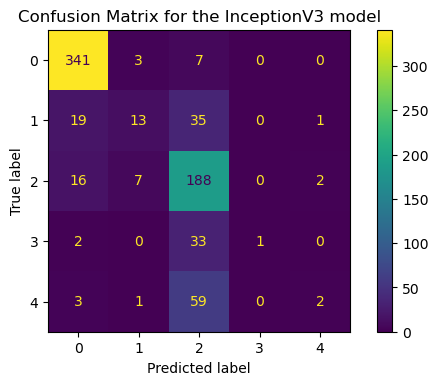

In [51]:
# confusion matrix heatmap
confusion_heatmap(inceptionResnet_conf_matrix)

In [52]:
# weighted average specificity
inceptionResnet_wa_specificity = weighted_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_wa_specificity)

[351, 68, 213, 36, 65]
0.8730434973563819


In [53]:
# macro avg specificity
inceptionResnet_ma_specificity = macro_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_ma_specificity)

0.923312655815069


In [54]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(inceptionResnet_y_pred)
print("InceptionResNet Micro-Average AUC:", micro_avg_auc)


InceptionResNet Micro-Average AUC: 0.8905116213710567


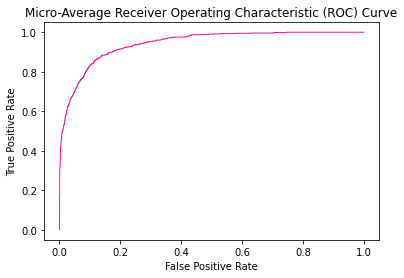

In [55]:
roc_plot(inceptionResnet_y_pred)

## Averaging

In [72]:
model1 = InceptionV3_model
model2 = resnet152_model
model3 = inceptionResnet_model

In [73]:
models = [model1, model2, model3]

In [74]:
preds = [model.predict(X_test) for model in models]

23/23 [==============================] - 47s 2s/step


In [75]:
pred = np.array(preds)

In [76]:
summed = np.sum(preds, axis=0)


In [77]:
mean_preds = np.mean(preds, axis = 0)

In [78]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [79]:
print(classification_report(y_test, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       351
           1       0.64      0.10      0.18        68
           2       0.60      0.91      0.72       213
           3       1.00      0.03      0.05        36
           4       1.00      0.02      0.03        65

    accuracy                           0.75       733
   macro avg       0.82      0.41      0.38       733
weighted avg       0.79      0.75      0.67       733



In [80]:
# Confusion matrix
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_prediction)

print(ensemble_conf_matrix)

[[345   3   3   0   0]
 [ 21   7  40   0   0]
 [ 18   1 194   0   0]
 [  4   0  31   1   0]
 [  6   0  58   0   1]]


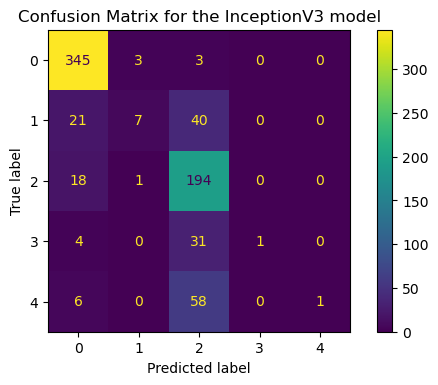

In [81]:
# confusion matrix
confusion_heatmap(ensemble_conf_matrix)

In [82]:
# weighted average specificity
ensemble_wa_specificity = weighted_average_specificity(ensemble_conf_matrix)
print(ensemble_wa_specificity)

[351, 68, 213, 36, 65]
0.8642540060913427


In [83]:
# macro avg specificity
ensemble_ma_specificity = macro_average_specificity(ensemble_conf_matrix)
print(inceptionResnet_ma_specificity)

0.923312655815069


In [84]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(mean_preds)
print("Ensembled model Micro-Average AUC:", micro_avg_auc)


Ensembled model Micro-Average AUC: 0.8999335914329236


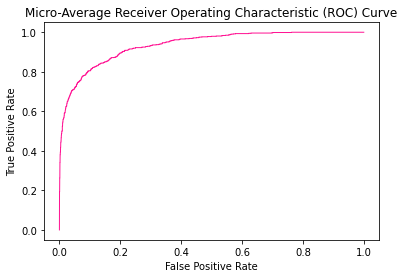

In [85]:
roc_plot(mean_preds)

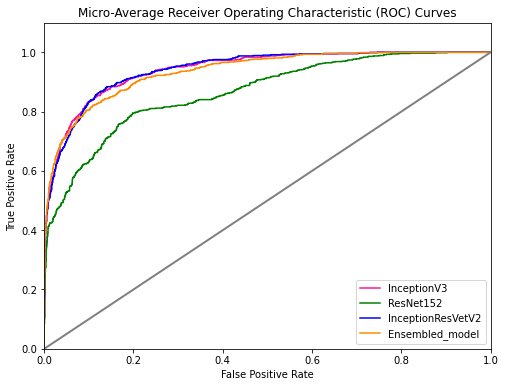

In [86]:
# Encode actual test labels 
y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))
# Compute the ROC curves and AUC scores for each model
fpr_inception, tpr_inception, _ = roc_curve(y_test_cat.ravel(), inceptionv3_y_pred.ravel())
fpr_resnet, tpr_resnet, _ = roc_curve(y_test_cat.ravel(), resnet152_y_pred.ravel())
fpr_inceptionResnet, tpr_inceptionResnet, _ = roc_curve(y_test_cat.ravel(), inceptionResnet_y_pred.ravel())
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_cat.ravel(), mean_preds.ravel())

# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))

plt.plot(fpr_inception, tpr_inception, color='deeppink', lw=1.5, label= 'InceptionV3')
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=1.5, label= 'ResNet152')
plt.plot(fpr_inceptionResnet, tpr_inceptionResnet, color='blue', lw=1.5, label= 'InceptionResVetV2')
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=1.5, label= 'Ensembled_model')
 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()